# Importing Libraries

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import easyocr
import torch
import numpy as np
from ultralytics import YOLO

# Install Ultralytics

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.5/627.5 kB 26.9 MB/s eta 0:00:00


# Uploading Dataset

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PJ8OjvRxM1f1W929Ksq7")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
dataset = project.version(2).download("yolov8")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=7945cf17fef81aa1b4f64848aafa5f0c2721b14c725f39c9627a1ae7a9689aaf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found e

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.132, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to License-Plate-Recognition-2 in yolov8:: 100%|██████████| 20264/20264 [00:04<00:00, 4143.04it/s]


# Training YOLOv8 Model version s

In [5]:
model = YOLO('yolov8s')

model.train(data='/content/License-Plate-Recognition-2/data.yaml', epochs=15, batch=-1)

100%|██████████| 21.5M/21.5M [00:01<00:00, 18.1MB/s]
Ultralytics YOLOv8.0.132 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/License-Plate-Recognition-2/data.yaml, epochs=15, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=

# Choosing the best weights the model achieved as our prediction model

In [3]:
model = YOLO('runs/detect/train/weights/best.pt')

# Our Predict Function

In [18]:
def predict(image_path):
    # reading the image
    image = cv2.imread(image_path)

    # predicting the results
    results = model.predict(image, save=True, conf=0.25, iou=0.2)
    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Class probabilities for classification outputs

    # slicing the results.boxes
    tensor = torch.tensor(boxes.data)
    tensor_cpu = tensor.cpu()
    numpy_array = np.array(tensor_cpu)
    detection = numpy_array[0]
    bbox = []
    for cord in detection[:-2]:
        cord = int(cord)
        bbox.append(cord)

    # Function to crop the image based on the bounding box
    def crop_image(image, bounding_box):
        x, y, h, w = bounding_box
        roi = image[y:w, x:h]
        return roi

    roi = crop_image(image, bbox)

    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'], gpu=False)

    # Perform OCR on the cropped image
    ocr_result = reader.readtext(roi)

    # Function to filter the extracted text based on a threshold
    def filter_text(roi, ocr_result, roi_threshold):
        rectangle_size = roi.shape[0] * roi.shape[1]

        plate = []

        for result in ocr_result:
            length = np.sum(np.subtract(result[0][1], result[0][0]))
            height = np.sum(np.subtract(result[0][2], result[0][1]))

            if length * height / rectangle_size > roi_threshold:
                plate.append(result[1])
        return plate

    plate_number = filter_text(roi, ocr_result, roi_threshold=0.3)

    # Display the cropped image with bounding box and print the extracted plate number
    plt.imshow(roi)
    print(plate_number)



0: 448x640 1 License_Plate, 259.6ms
Speed: 5.0ms preprocess, 259.6ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict16
C:\Users\amr\AppData\Local\Temp\ipykernel_38552\3056939878.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(boxes.data)
Using CPU. Note: This module is much faster with a GPU.


['GX67 TKZ']


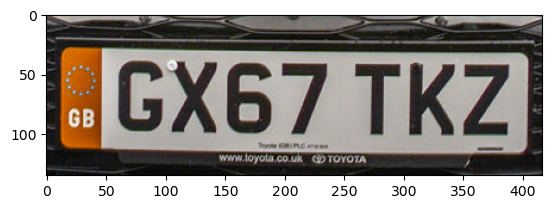

In [19]:
predict('data/custom test data/Toyota-Yaris-GRMN-Review-Front-carwitter.jpg')


0: 320x640 1 License_Plate, 233.0ms
Speed: 3.0ms preprocess, 233.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs\detect\predict16
C:\Users\amr\AppData\Local\Temp\ipykernel_38552\3056939878.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(boxes.data)
Using CPU. Note: This module is much faster with a GPU.


['KY7O CHT']


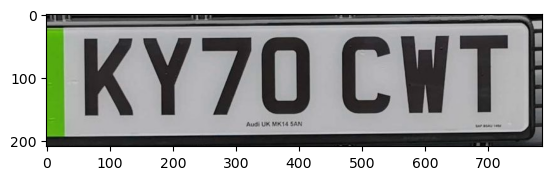

In [23]:
predict('data/custom test data/IMG_20210201_113303-scaled-e1612179429759.jpg')


0: 480x640 1 License_Plate, 284.6ms
Speed: 4.0ms preprocess, 284.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict16
C:\Users\amr\AppData\Local\Temp\ipykernel_38552\3056939878.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(boxes.data)
Using CPU. Note: This module is much faster with a GPU.


['UP16 TC 2808']


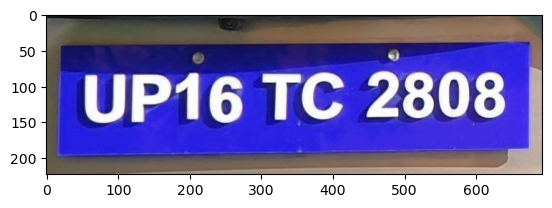

In [20]:
predict('data/custom test data/2.jpg')


0: 416x640 1 License_Plate, 274.0ms
Speed: 2.0ms preprocess, 274.0ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict16
C:\Users\amr\AppData\Local\Temp\ipykernel_38552\3056939878.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(boxes.data)
Using CPU. Note: This module is much faster with a GPU.


['SN66 XMZ']


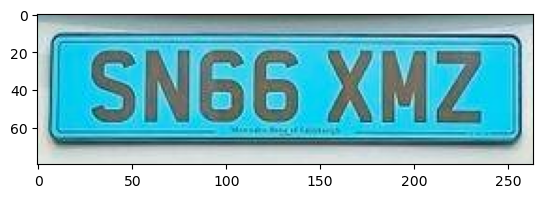

In [21]:
predict('data/custom test data/why-are-number-plates-yellow-and-white.jpg')


0: 384x640 1 License_Plate, 250.1ms
Speed: 2.0ms preprocess, 250.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict16
C:\Users\amr\AppData\Local\Temp\ipykernel_38552\3056939878.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(boxes.data)
Using CPU. Note: This module is much faster with a GPU.


['LR33TEB']


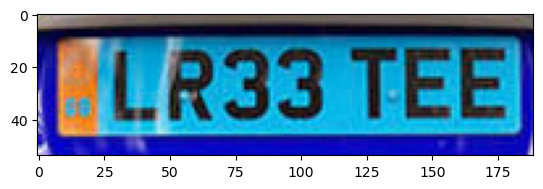

In [22]:
predict('data/custom test data/847566.jpg')